# Basic Matrix Factorization

In [1]:
import torch

class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors, sparse=True)
        self.item_factors = torch.nn.Embedding(n_items, n_factors, sparse=True)
    def forward(self, user, item):
        return (self.user_factors(user)*self.item_factors(item)).sum(1)
    def predict(self, user, item):
        return self.forward(user, item)


In [3]:
import pandas as pd

query = """
SELECT *
FROM EVIC.ratings
"""
ratings = pd.read_gbq(query, project_id="spike-sandbox", use_bqstorage_api=True)

In [16]:
ratings_sample

,user_id,movie_id,rating
0,6,4369,2.0
1,8,4992,2.0
2,8,5609,2.0
3,8,5833,2.0
4,12,3593,2.0
...,...,...,...
9982177,3067,736,1.5
9982178,3104,4848,1.5
9982179,3106,6295,1.5
9982180,3106,47122,1.5


In [98]:
sample_users = 300
ratings_sample = ratings[ratings.user_id.isin(ratings.user_id.unique()[0:sample_users])].copy()
ratings_matrix = pd.pivot_table(ratings_sample, index='user_id', columns='movie_id', values='rating')
ratings_matrix.fillna(0., inplace=True)
ratings_matrix = ratings_matrix.values
torch_ratings_matrix = torch.from_numpy(ratings_matrix)  

In [99]:
n_users = ratings_matrix.shape[0]
n_items = ratings_matrix.shape[1]
items = range(0, n_items)
users = range(0, n_users)


In [100]:
n_users, n_items

(300, 6025)

In [71]:
import random

In [109]:
## Training loop
#Movielens dataset with ratings scaled between [0, 1] to help with convergence.on the test set, error(RMSE) of 0.66
import itertools

model = MatrixFactorization(n_users, n_items, n_factors=20)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)

losses = []
epochs = range(0, 1)
combinations = list(itertools.product(users, items))
for epoch in epochs:
    for j, (user, item) in enumerate(combinations):
        # get user, item and rating data
        rating = torch.FloatTensor([torch_ratings_matrix[user, item]])
        user = torch.LongTensor([int(user)])
        item = torch.LongTensor([int(item)])
        # predict
        prediction = model(user, item)
        loss = loss_fn(prediction, rating)
        losses += [loss.cpu().detach().tolist()]
        # backpropagate
        loss.backward()
        # update weights
        optimizer.step()
        
        if j%100_000 == 0:
            print(f"{j} out of {len(combinations)}")
    epoch += 1

0 out of 1807500


KeyboardInterrupt: 

In [30]:
from numba import njit
import numpy as np
import time

#Preallocate with expected number of larger than 0 dot products
larger_than_0_prods = 100_000_000


def filtered(user_embs, product_embs, min_cross_prod=0.):
    """
    Calculates dot product between user_embs and product_embs
    but keeps only the ones with 
    """
    filtered_m = np.empty(larger_than_0_prods, dtype=np.float32)
    filtered_user_prod_ids = np.empty((larger_than_0_prods, 2), dtype=np.int32)
    larger_than_0_count = 0
    
    for user_id in range(0, len(user_embs)):
        for prod_id in range(0, len(product_embs)):
            
            dot_prod = np.dot(product_embs[prod_id], user_embs[user_id])
            if dot_prod > min_cross_prod:
                filtered_m[larger_than_0_count] = dot_prod
                filtered_user_prod_ids[larger_than_0_count][0] = user_id
                filtered_user_prod_ids[larger_than_0_count][1] = prod_id
                larger_than_0_count += 1

                                   
    return filtered_m, filtered_user_prod_ids





In [17]:
from numba import jit

In [41]:
@jit(nopython=True, nogil=True)
def njit_filtered(user_embs, product_embs, min_cross_prod=5.5):
    """
    Calculates dot product between user_embs and product_embs
    but keeps only the ones with dot producto > min_cross_prod
    """
    filtered_m = np.empty(larger_than_0_prods, dtype=np.float64)
    filtered_user_prod_ids = np.empty((larger_than_0_prods, 2), dtype=np.int64)
    larger_than_0_count = 0
    
    for user_id in range(0, len(user_embs)):
        for prod_id in range(0, len(product_embs)):            
            dot_prod = np.dot(product_embs[prod_id], user_embs[user_id])
            if dot_prod > min_cross_prod:
                filtered_m[larger_than_0_count] = dot_prod
                filtered_user_prod_ids[larger_than_0_count][0] = user_id
                filtered_user_prod_ids[larger_than_0_count][1] = prod_id
                larger_than_0_count += 1

                                   
    return filtered_m, filtered_user_prod_ids
                

In [46]:
n_users = 1_000_000
n_prods = 10_000
n_factors = 30

def convert_to_32(x):
    return np.array(x, dtype=np.float32)
user_embs = np.random.randn(n_users, n_factors)
product_embs = np.random.randn(n_prods, n_factors)



In [33]:
start = time.time()
filtered_m, filtered_user_prod_ids = filtered(user_embs,
                                              product_embs, min_cross_prod=5.5)
time1 = (time.time() - start)/60
print(f"{n_users * n_prods} combinations done in {time1} mins")

50000000 combinations done in 1.3086119691530864 mins


In [47]:
start = time.time()

filtered_m, filtered_user_prod_ids = njit_filtered(user_embs, product_embs,
                                                   min_cross_prod=35.5)
time2 = (time.time() - start)/60
print(f"{n_users * n_prods} combinations done in {time2} mins")
print(f"speedup: {time1/time2}")

10000000000 combinations done in 8.777861479918162 mins
speedup: 0.14908095464332696


In [ ]:
%%cython

import numpy as np
cimport numpy as np
DTYPE = np.int
ctypedef np.int_t DTYPE_t
ctypedef np.float_t DTYPEF_t


def f(np.ndarray[DTYPEF_t, ndim=1] user_embs,
      product_embs, float min_cross_prod):
    """
    Modifies 
    """
    cdef np.ndarray[DTYPEF_t, ndim=2] filtered_m = np.empty(non_zero_combinations, dtype=np.float32)
    filtered_user_prod_ids = np.empty((non_zero_combinations, 2), dtype=np.int32)
    non_zero_count = 0
    
    for user_id in range(0, len(user_embs)):
        for prod_id in range(0, len(product_embs)):
            
            dot_prod = np.dot(product_embs[prod_id], user_embs[user_id])
            if dot_prod > min_cross_prod:
                filtered_m[non_zero_count] = dot_prod
                filtered_user_prod_ids[non_zero_count] = [user_id, prod_id]
                non_zero_count += 1

                                   
    return filtered_m, filtered_user_prod_ids

In [133]:
len(prods_embs)º

1000

In [ ]:
import time
start = time.time()
filtered_m, filtered_user_prod_ids = f(user_embs, product_embs, min_cross_prod=0.)

print(f"{n_users * n_prods} combinations done in {(time.time() - start)/60} mins")

In [ ]:
2+3

In [ ]:
2+2

In [ ]:
for epoch in range(epochs):
    epoch_loss = train_one_epoch( model, training_data_generator, loss_fn, optimizer, epoch, device)
    


In [106]:

len(avers)

1807500

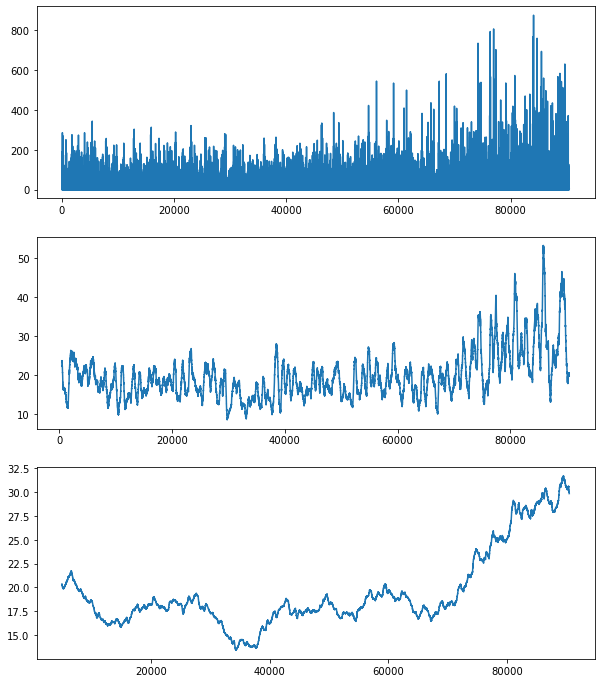

In [104]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
axes[0].plot(losses)
axes[1].plot(pd.Series(losses).rolling(window=500).mean())
axes[2].plot(pd.Series(losses).rolling(window=5000).mean())

In [60]:
detached.tolist()

1.4431205987930298

In [43]:
%matplotlib inline


[]

In [52]:
losses[0]

array(18.055532, dtype=float32)